In [2]:
import analysis
import importlib

importlib.reload(analysis)

analysis.calculate_indentations() # gets us indentations_counts, might take a while
analysis.read_results() # gets us is_real

In [3]:
import numpy as np
import graphs
importlib.reload(graphs)

<module 'graphs' from '/home/vojtechnovotny/school/code-depth-analysis/graphs.py'>

# Is indention the identification?
### Vojtěch Novotný

In this work I would like explore an interesting way to judge whether a repository is real code (like libraries) or not (exercises, tutorials etc.). This has been a problem for quite some time and while it's easy to do it by hand, _to my knowledge_ a good way to do so automatically is yet to be found. 

Recently artificial inteligence is on the rise and this honestly sounds like a great place for it, but running that at scale might be too expensive. I propose that one could use basic statistics to have a good guess on whether a repository is _real_.

To be more exact, this analysis tests whether one can judge a repository based on the code depth (for example in python the indentation). The rationale behind this is that tutorials and other non-code repositories will have much more tidy structure, therefore on average **low code depth**. Not only that, but also any code used is coded so that it's as simple to follow as possible. Yes, that _should_ be true for any code, but let's be honest to ourselfs, it is not. On top of that, making it easy to follow for <u>fellow programmers</u>  is quite different from making it easy for <u>students</u>. That could therefore lead to **more "stable" code depth**, as you don't need many levels of identation to show some simple list operations. 

## Method

While judging a repository by hand is easy, all the hassle around it is quite annoying and having to do it hundreds of times sounds terribly time and space consuming. Also counting the indentations would taky way to long. So I have decided to settle on 30 repositories with ok representations of _real_ and _unreal_.

We will be trying to disprove two null hypothesis. First is "The average indentation of python files in a python repository cannot be use to indicate a real repository" and second is similar, but instead of average, we will look at deviation.

The method we will use is Mann–Whitney U-test, because on 30 samples measuring normality is not ideal and Mann-Whitney U-test does not need normality. But first I will render some graphs because I like graphs.

/home/vojtechnovotny/.local/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/vojtechnovotny/.local/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/vojtechnovotny/.local/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/vojtechnovotny/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:571: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/vojtechnovotny/.local/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


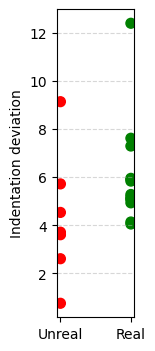

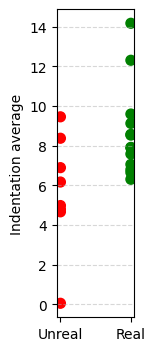

In [4]:
deviations = [np.std(arr) for arr in analysis.indentations_counts]
averages = [np.average(arr) for arr in analysis.indentations_counts]

graphs.chart(deviations, "Indentation deviation", analysis.is_real)
graphs.chart(averages, "Indentation average", analysis.is_real)

In the graphs one can already see a pattern, but graphs like to lie. For example, there is an easily-countable number of outliers that make it look way more extreme than it is. Let's run a _real_ test, we are looking for p_values < 0.05 ...

In [5]:
from scipy.stats import mannwhitneyu

def test(data):
    group_true_dev = [v for v, f in zip(data, analysis.is_real) if f]
    group_true_dev_clean = [s for s in group_true_dev if not np.isnan(s)]
    group_false_dev = [v for v, f in zip(data, analysis.is_real) if not f]
    group_false_dev_clean = [s for s in group_false_dev if not np.isnan(s)]

    u_stat, p_val = mannwhitneyu(group_true_dev_clean, group_false_dev_clean)
    return p_val

print(f"P-value for deviation: {test(deviations):.3f}")
print(f"P-value for average: {test(averages):.3f}")


P-value for deviation: 0.025
P-value for average: 0.020


There we have it. Null hypothesis has been disproven.

## Conclusion

While this analysis has succesfully concluded that one can measure code depth to make a better guess on whether a repository is real, it's obviously not a clear decider. And even if it could be, this work has only picked 30 repos (less than that actually, some had 0 python files, so they were not valid. I could probably pick them out, but I decided to leave them in to show the existance of this problem) and all from the top repos on github, results may vary for less popular frameworks and tutorials. 

On top of that, the reason, why I tested only 30 repos, is another flaw of this method by itself. Running this is very slow for how little information the results give us. And I'm assuming that you have all the repos pulled in the first place! 

Still I believe that the results and idea of this paper may be good to know for further exploration of judging a repo by statically analysing code quality.